# Overview
In the last lab and in the homework, we saw how we can model the response of a voxel $v$ to a stimulus $i$ via the hemodynamic response function, and a weight $\beta^v_i$. To do this we assume that we know the shape of the hemodynamic response, and we assume a value for how well a voxel responds to a stimulus. But in reality, we do not know these. The hemodynamic response has been a subject for a lot of research and therefore it is common to use a canonical function like the one we explored last week. However, estimating how much a voxel responds to a specific stimulus is exactly what the purpose of an fMRI experiment is.

# Goals
Here, we will go over how we can use linear regression to estimate how much a voxel responds to each stimulus in an experiment. We will first explain the regression problem and derive it's solution. We will then apply this analysis to real data.

In [ ]:
# Imports
import neurods as nds
import numpy as np
import os
import matplotlib.pyplot as plt
# Configure defaults for plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.cmap'] = 'viridis'
%matplotlib inline

First let's talk about linear regression, and start to work with a simple problem. Let's say you walk into a grocery store, and you buy 3 oranges and 2 apples. You are told the price is 8\$. You go another time, you buy 2 oranges and 5 apples, you pay 9\$. How much do apples and oranges cost?

This is a system of two equations with two unknown that you can solve and obtain an exact solution.

However, imagine that the cashier doesn't tell you the exact price, but takes the correct price, and then depending on their mood, adds some "noise" to the price: you either pay a little less or a little more. This noise doesn't depend on how much your total is, but on other unrelated factors.

Can you still estimate accurately the prices if you go twice to the store?

What if you go 1000 times?

Let's simulate this with a random sample:

In [ ]:
# these are the hidden parameters, we are not supposed to know them:
apple_price = 0.9
orange_price = 1.2
pear_price = 1.5
noise_variance = 5

# sample X and Y:
n = 1000
X = np.round(np.random.uniform(low = 0, high = 10, size=[n,3])).astype(int)
real_beta = np.array([apple_price, orange_price, pear_price]).reshape([3,1])
Y = np.dot(X, real_beta) + np.random.normal(size =[n,1] )*noise_variance

We can express the price in one visit j as:

\begin{align}
y_j =  X_j \beta +\epsilon_j
\end{align}

Were the row $X_j = [x^a_j,x^o_j,x^p_j]$ corresponds to the counts $x^a_j,x^o_j,x^p_j$ of apples, oranges and pears bought on visit $j$, and $\beta = [\beta_a,\beta_o,\beta_p]$ corresponds to the prices  $\beta_a,\beta_o,\beta_p$ of apples, oranges and pears. 

We can write the entire visits as:

\begin{align}
Y =  {\bf X} \beta +\epsilon
\end{align}

where
- $Y$ is n x 1
- ${\bf X}$ is n x d, here d = 3
- ${\beta}$ is d x 1
- $\epsilon$ is n x 1.

Due to the noise, we cannot exactly recover $\beta$. However, we would like to find a solution $\hat\beta$ that minimizes the following error as much as possible:

\begin{align}
error = \sum_{j = 1}^N (y_j - X_j \beta)^2 = ||Y - {\bf X} \beta||_2^2
\end{align}

This is the sum of squared errors. To minimize this equation with respect to $\beta$, we first find the derivative with respect to $\beta$:

\begin{align}
\frac{\delta \ error}{\delta \beta} &=& \frac{\delta ||Y - {\bf X} \beta||_2^2}{\delta \beta}\\
 &=& -2{\bf X}^\top (Y - {\bf X} \beta)\\
\end{align}

The minimum is achieved when the derivative is zero:

\begin{align}
-2{\bf X}^\top (Y - {\bf X} \hat\beta) = 0\\
{\bf X}^\top Y = {\bf X}^\top{\bf X} \hat\beta\\
\hat\beta = ({\bf X}^\top{\bf X})^{-1}{\bf X}^\top Y\\
\end{align}

This is the Ordinary Least Squares Solution. Now write it as a function, then use this function to recover the prices of the fruits, using the following cell:

### BREAKOUT SESSION

In [58]:
from numpy.linalg import inv
def OLS(X,Y):
### STUDENT ANSWER
    return np.dot(inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [66]:
prices = OLS(X,Y)
print("apple price: real {0} estimated {1}".format(apple_price,prices[0,0]))
print("orange price: real {0} estimated {1}".format(orange_price,prices[1,0]))
print("pear price: real {0} estimated {1}".format(pear_price,prices[2,0]))

apple price: real 0.9 estimated 1.0057617622736301
orange price: real 1.2 estimated 1.1510736844799787
pear price: real 1.5 estimated 1.4136412063946673


Try to change the number of datapoints and the magnitude of the noise, what do you notice?

## Intercept Term

Many times, we are interested in modeling $y_j$ as:

\begin{align}
y_j =  \beta_0 + \beta_1 x^1_j + \beta_2 x^2_j ... + \beta_3 x^d_j +\epsilon_j
\end{align}

this means there is a constant intercept term which is always contributed to the output $y_j$. In our store analogy, this could be for example an additional flat fare that is added by the cashier for each costumer. How can we integrate the intercept term in our framework?

There is a simple way, notice how we can rewrite the above equation as:

\begin{align}
y_j =  \beta_0 x^0_j+ \beta_1 x^1_j + \beta_2 x^2_j ... + \beta_3 x^d_j +\epsilon_j
\end{align}

where $x^0_j$ is always equal to 1. This can be done by creating a matrix $X'$ by adding an additional column to our matrix $X$ which is all ones. Let's try to estimate the intercept term in our fruit example:


In [67]:
X2 = np.hstack([np.ones([n,1]),X])
prices = OLS(X2,Y)
print('intercept term is estimated to be {0}'.format(prices[0,0]))
print("apple price: real {0} estimated {1}".format(apple_price,prices[1,0]))
print("orange price: real {0} estimated {1}".format(orange_price,prices[2,0]))
print("pear price: real {0} estimated {1}".format(pear_price,prices[3,0]))

intercept term is estimated to be -0.03113375273494512
apple price: real 0.9 estimated 1.0075965051226365
orange price: real 1.2 estimated 1.152885957918842
pear price: real 1.5 estimated 1.4156192481930177


The intercept term is estimated to be 0, which makes sense because we didn't specify an intercept term! Let's sample data another time and estimate the intercept again:

In [69]:
intercept_term = 2
Y2 = np.dot(X, real_beta) + np.random.normal(size =[n,1] )*noise_variance + intercept_term

prices = OLS(X2,Y2)
print('intercept term is estimated to be {0}'.format(prices[0,0]))
print("apple price: real {0} estimated {1}".format(apple_price,prices[1,0]))
print("orange price: real {0} estimated {1}".format(orange_price,prices[2,0]))
print("pear price: real {0} estimated {1}".format(pear_price,prices[3,0]))

intercept term is estimated to be 2.3398269251306374
apple price: real 0.9 estimated 0.8694543341732448
orange price: real 1.2 estimated 1.1707869904084967
pear price: real 1.5 estimated 1.4611908705417225


When we work with fMRI data, we usually remove the mean of each voxel in the begining of our analysis. This means we don't need to include the intercept term in our design matrix, because it's effectively equal to zero.

# Modeling voxel responses

Remember, we are using regression because we want to model different voxel responses to a set of stimuli. We learned how to take a stimulus time course and how to convolve it with the hemodynamic response. We then assumed that each voxel's activity was a linear combination of all the convolved time courses of the stimuli. We want to recover the parameters of the linear combination. Let's load some data:

Experiment design variables:  ['run2', 'run3', 'conditions', 'run1']
Conditions:  ['body', 'faces', 'object', 'places', 'scrambled']


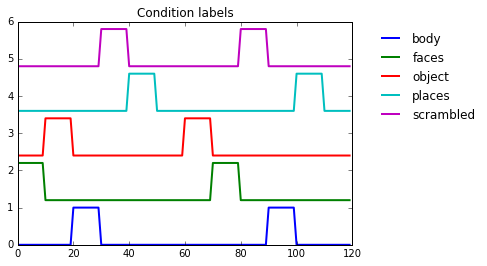

In [78]:
design = np.load('../../data/fMRI/categories/experiment_design.npz')
print('Experiment design variables: ', design.keys())
conditions = design['conditions'].tolist()
print('Conditions: ', conditions)
design_run1 = design['run1']
for i, (cond, label) in enumerate(zip(design_run1.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

To normalize a matrix, we can use the zscore function:

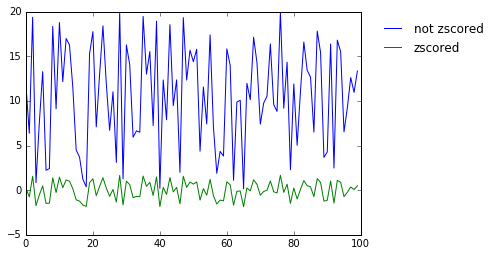

In [83]:
from scipy.stats import zscore
a = 20*np.random.uniform(size=[100,1])
a_zs = zscore(a, axis = 0)
plt.plot(a, label = 'not zscored')
plt.plot(a_zs, label = 'zscored')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We are going to use the zscore function while loading the data to normalize every block:

In [120]:
import cortex
sub, xfm = 'S1', 'fullhead' #'S2', 'S2_category_auto'
mask = cortex.db.get_mask(sub, xfm, type='cortical')
fname = os.path.join(basedir, 'sub01_categories1_{n}.nii.gz') #S2_categories1_{n}.nii.gz
basedir = os.path.join('../../data/fMRI/', 'categories') #nds.io.data_list['fmri']
data_2runs = np.vstack([zscore(nds.fmri.load_data(fname.format(n=n), mask=mask, standardize=True)) for n in [1,2]])
design_2runs = np.vstack([design[run] for run in ['run1','run2']])

Mask not found, generating...
0.000%
0.140%
0.279%
0.419%
0.558%
0.698%
0.837%
0.977%
1.116%
1.256%
1.395%
1.535%
1.674%
1.814%
1.953%
2.093%
2.233%
2.372%
2.512%
2.651%
2.791%
2.930%
3.070%
3.209%
3.349%
3.488%
3.628%
3.767%
3.907%
4.046%
4.186%
4.326%
4.465%
4.605%
4.744%
4.884%
5.023%
5.163%
5.302%
5.442%
5.581%
5.721%
5.860%
6.000%
6.140%
6.279%
6.419%
6.558%
6.698%
6.837%
6.977%
7.116%
7.256%
7.395%
7.535%
7.674%
7.814%
7.953%
8.093%
8.233%
8.372%
8.512%
8.651%
8.791%
8.930%
9.070%
9.209%
9.349%
9.488%
9.628%
9.767%
9.907%
10.046%
10.186%
10.326%
10.465%
10.605%
10.744%
10.884%
11.023%
11.163%
11.302%
11.442%
11.581%
11.721%
11.860%
12.000%
12.139%
12.279%
12.419%
12.558%
12.698%
12.837%
12.977%
13.116%
13.256%
13.395%
13.535%
13.674%
13.814%
13.953%
14.093%
14.232%
14.372%
14.512%
14.651%
14.791%
14.930%
15.070%
15.209%
15.349%
15.488%
15.628%
15.767%
15.907%
16.046%
16.186%
16.326%
16.465%
16.605%
16.744%
16.884%
17.023%
17.163%
17.302%
17.442%
17.581%
17.721%
17.860%
18.000%
18

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/neurods-0.1-py3.5.egg/neurods/fmri.py:18: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 1; dimension is 30 but corresponding boolean dimension is 31
  data = data[:, mask]


We need to first build a design matrix that accounts for the hemodynamic response:

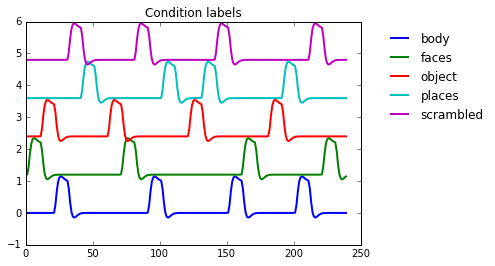

In [121]:
from neurods.fmri import hrf as generate_hrf
t_hrf, hrf_1 = generate_hrf(tr=2)
n, d = design_2runs.shape

conv_design = np.zeros_like(design_2runs)
for i in range(d):
    conv_design[:,i] = np.convolve(design_2runs[:,i], hrf_1)[:n]
    
for i, (cond, label) in enumerate(zip(conv_design.T, conditions)):
    plt.plot(cond+i+0.2*i, label=label, lw=2)
plt.title('Condition labels')
_ = plt.legend(frameon=False, bbox_to_anchor=(1.4, 1))

We want to find the response of all the voxels in the brain to these 5 different conditions. Instead of a one dimensional output $Y$, we have a high dimensional output ${\bf Y}$:

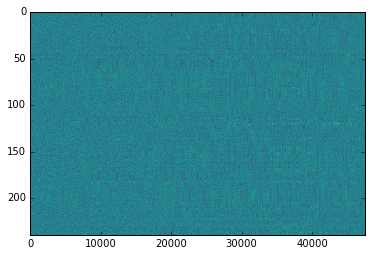

In [123]:
plt.imshow(data_2runs)

We want to learn how each voxel responds to the stimulus. For each voxel, we can write the linear model equation as:

\begin{align}
y^{v}_j =  X_j \beta^v +\epsilon_j^v
\end{align}

and:

\begin{align}
Y^{v} =  {\bf X} \beta^v +\epsilon^v
\end{align}

Since this model exist for every function, we can write it as a multiple regression function:
\begin{align}
{\bf Y} =  {\bf X} \boldsymbol\beta +\boldsymbol\epsilon
\end{align}

In the above:
- ${\bf Y}$ is n x nVoxels
- ${\bf X}$ is n x d
- ${\boldsymbol \beta}$ is d x nVoxels

Let's try to minimize the sum of squared errors like before with respect to $\boldsymbol\beta$, we first find the derivative:

\begin{align}
\frac{\delta \ error}{\delta \boldsymbol \beta} &=& \frac{\delta ||{\bf Y} - {\bf X} \boldsymbol \beta||_2^2}{\delta  \boldsymbol \beta}\\
 &=& -2{\bf X}^\top ({\bf Y} - {\bf X} \boldsymbol \beta)\\
\end{align}

The minimum is achieved when the derivative is zero:

\begin{align}
-2{\bf X}^\top ( {\bf Y} - {\bf X} \boldsymbol\beta) = 0\\
{\bf X}^\top {\bf Y} = {\bf X}^\top{\bf X}  \boldsymbol\beta\\
\boldsymbol \beta = ({\bf X}^\top{\bf X})^{-1}{\bf X}^\top {\bf Y}\\
\end{align}

This solution is similar to the single dimensional output solution. The first term $({\bf X}^\top{\bf X})^{-1}{\bf X}^\top$ is independent of the data. If we are estimating the parameters for one voxel, or for a large number, this term will be the same. 

Notice also that each voxel's parameters are estimated independently from each other: each column of $\boldsymbol \beta$ corresponds to the parameters of one voxel $v$, and it is obtained by multipling the matrix $({\bf X}^\top{\bf X})^{-1}{\bf X}^\top$ with the ${\bf Y}$ column that corresponds to voxel $v$.

Your OLS code for a single voxel should work for multiple outputs as well. Use it to estimate the weights for the 5 conditions for each voxel. Then, using cortex.quickflat.make_figure, make a flatmap plot of the parameters of each of the conditions across the brain.

### Breakout session


shape of weights is (5, 47530)
Generating a flatmap cache


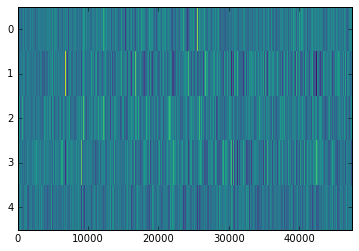

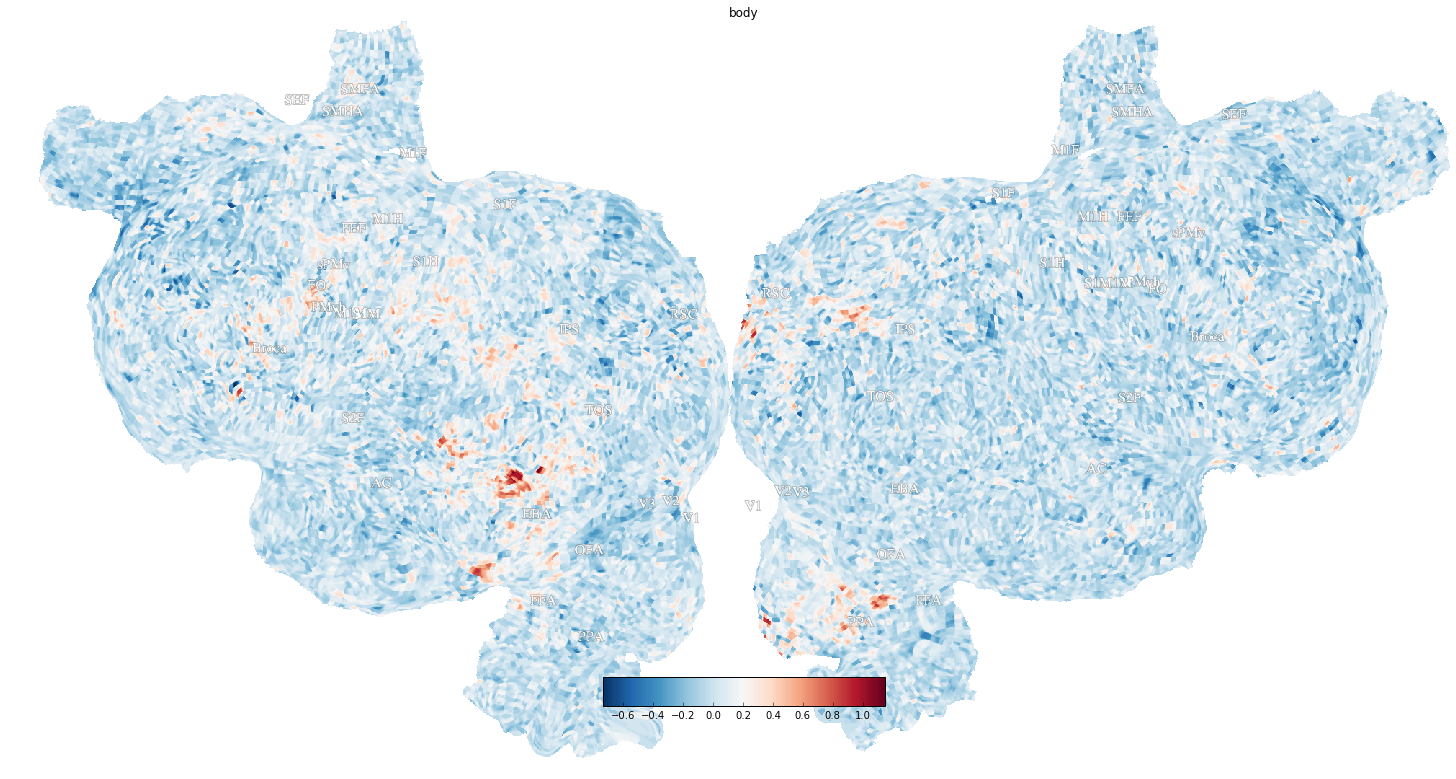

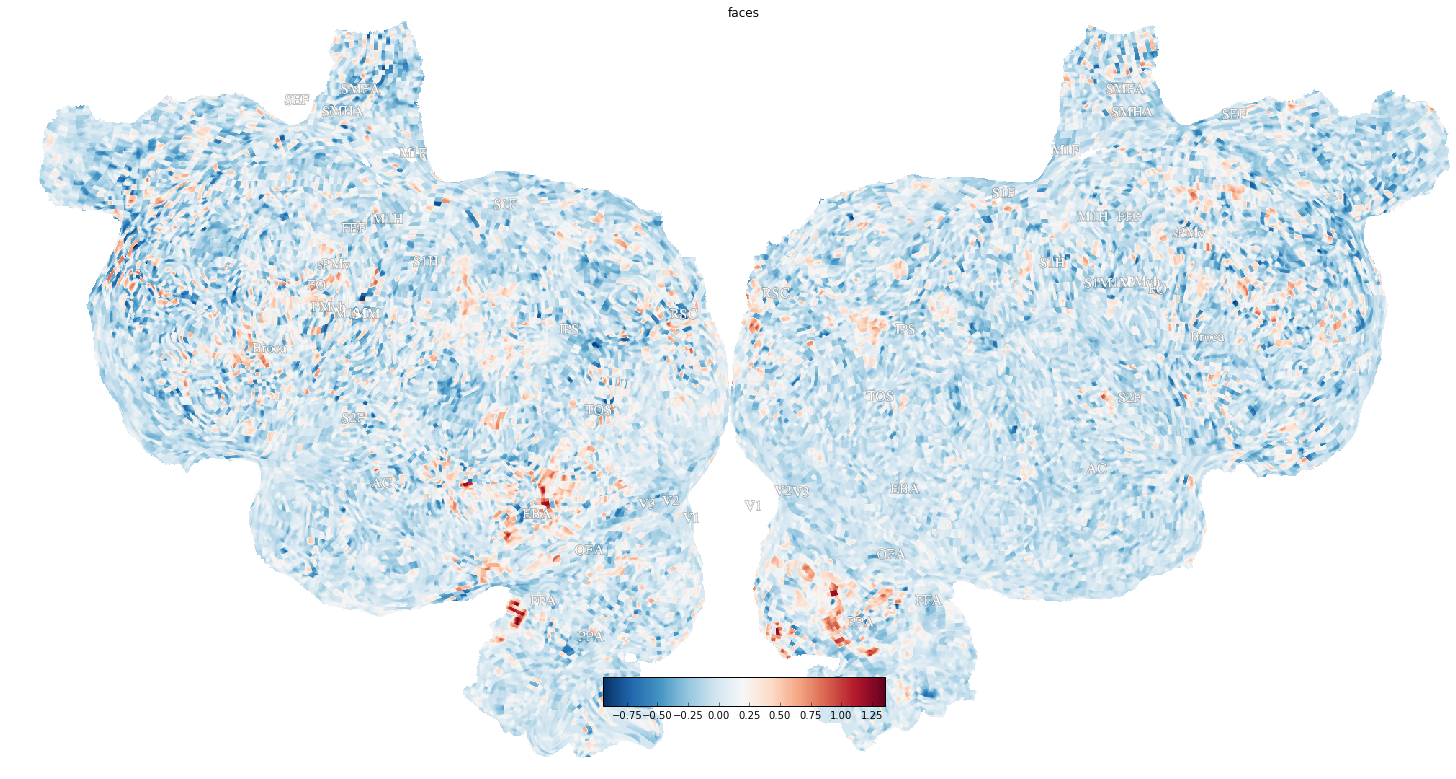

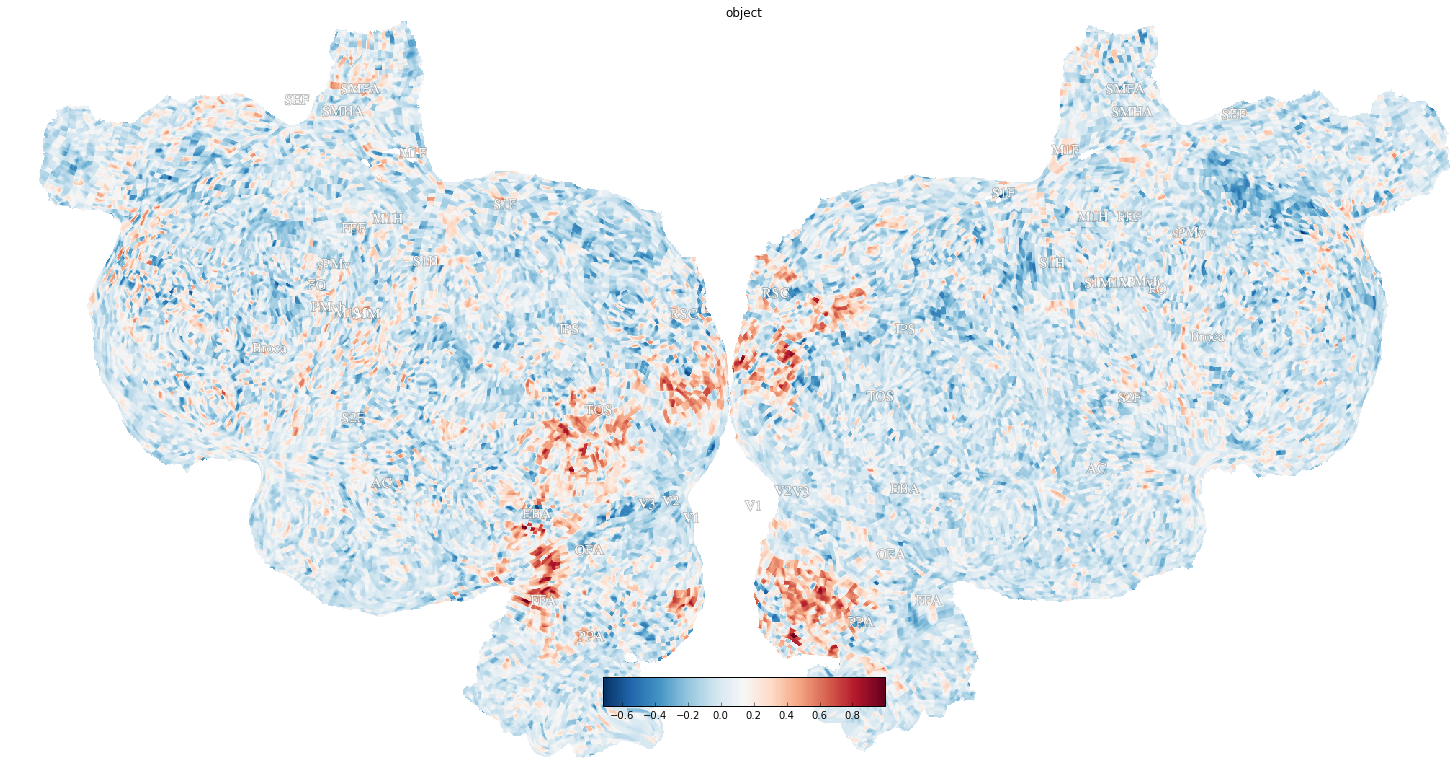

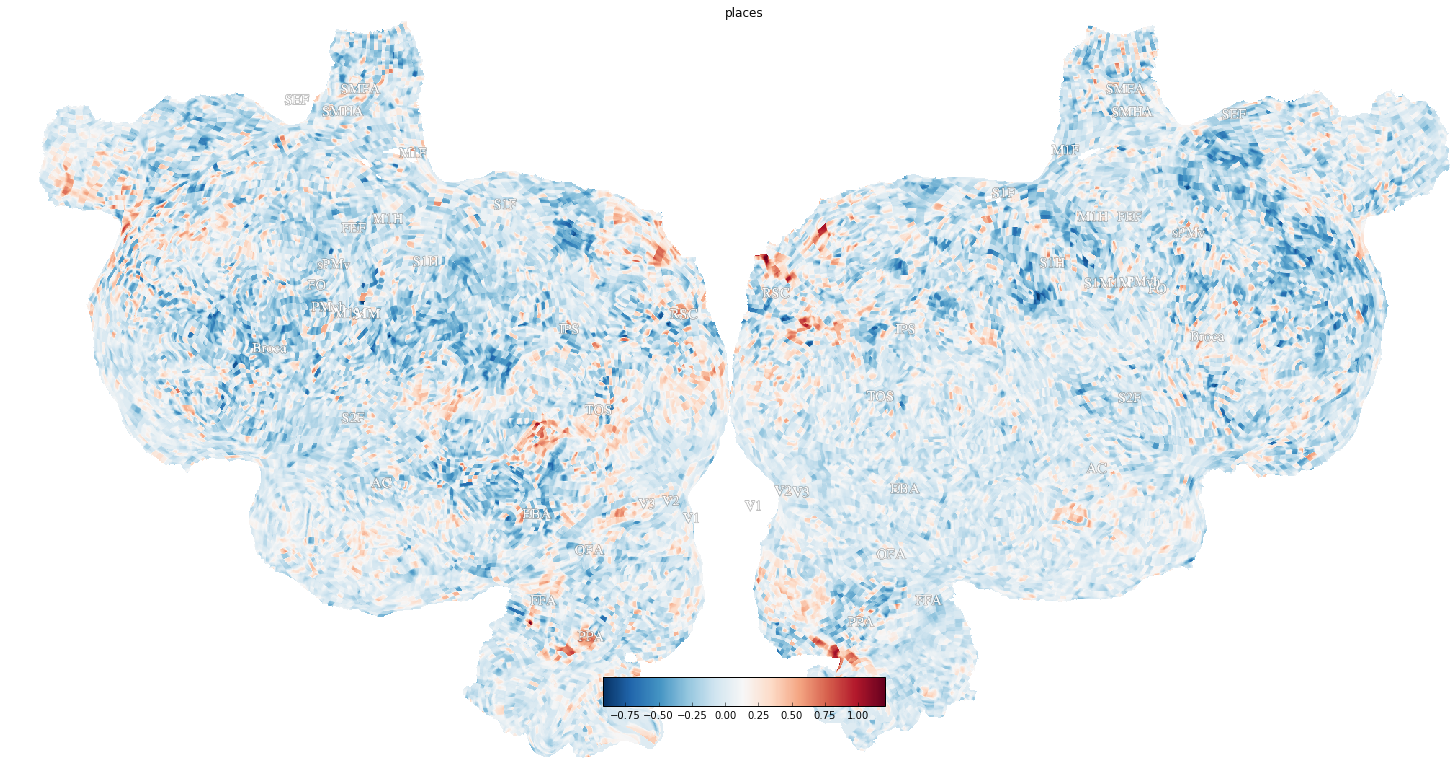

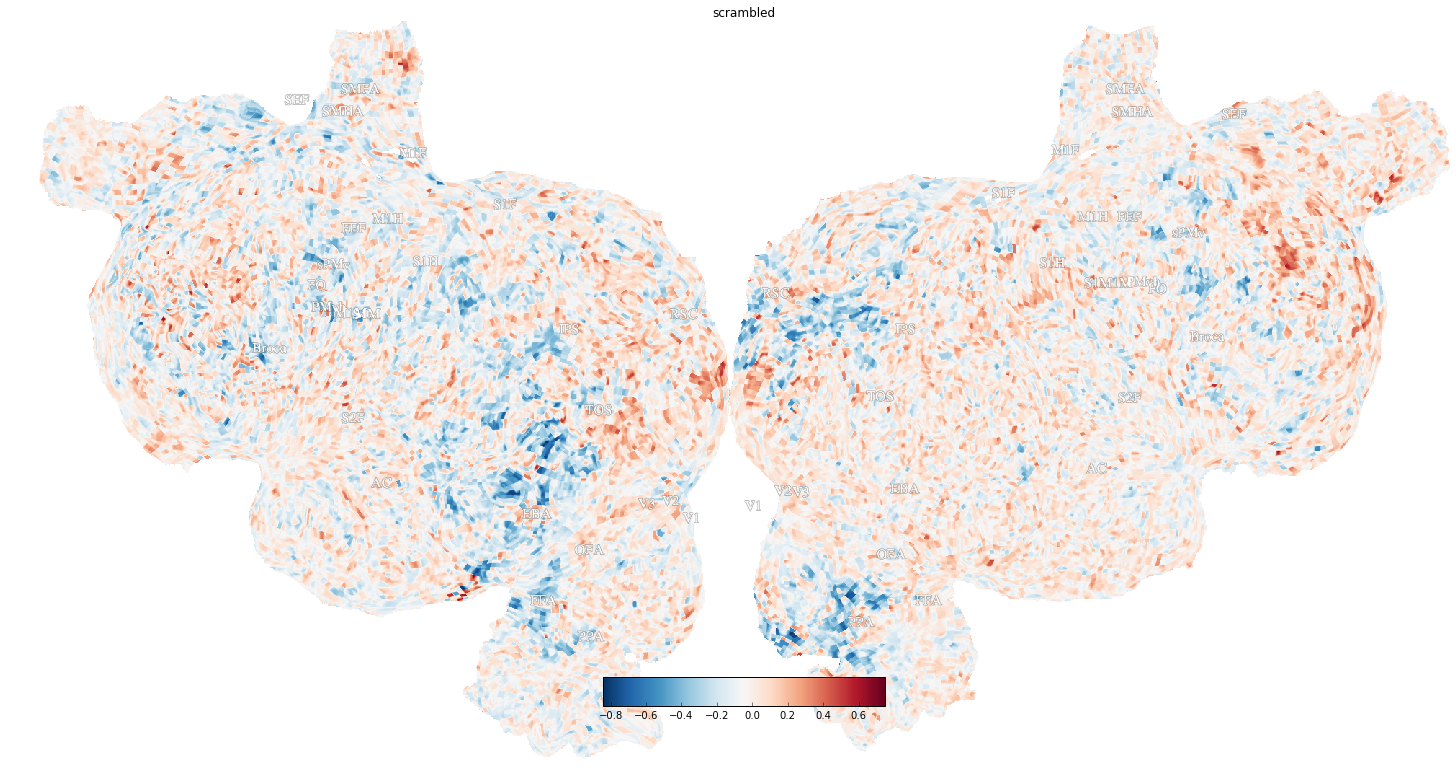

In [124]:
# vol = cortex.Volume(some_vector, sub, xfm, mask = mask)
# __  = cortex.quickflat.make_figure(vol)
# plt.title('some str')

### STUDENT ANSWER
weights = OLS(conv_design, data_2runs)
print('shape of weights is {}'.format(weights.shape))
plt.imshow(weights)
for idx, condition in enumerate(conditions):
    vol = cortex.Volume(weights[idx], sub, xfm, mask = mask)
    __  = cortex.quickflat.make_figure(vol)
    plt.title(condition)